In [3]:
from typing import List, Mapping
from itertools import zip_longest, chain
from glob import iglob
from pickle import load
from functools import partial, reduce

from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

In [4]:
runs = [326]
filenames = sorted(chain.from_iterable(iglob(f"/data/*/Run_{r:03d}/work/reduced.pickle") for r in runs if not r in {}))
print(f"Total {len(filenames)} files:")
for fn in filenames:
    print(f"    {fn}")

Total 1 files:
    /data/Step601N2/Run_326/work/reduced.pickle


In [5]:
def read_file(filename):
    with open(filename, 'br') as f:
        return load(f)


sumup = partial(reduce, partial(pd.DataFrame.add, fill_value=0))
summed = sumup(read_file(fn) for fn in filenames)
summed

sum   count
is_bg delay atmax                                                           
False -6.92 555    [[214.0, 207.0, 210.0, 216.0, 210.0, 204.0, 19...     2.0
            560    [[1789.0, 1821.0, 1771.0, 1814.0, 1798.0, 1751...    17.0
            565    [[36544.0, 36019.0, 36202.0, 36709.0, 36918.0,...   345.0
            570    [[201831.0, 200578.0, 200163.0, 203223.0, 2041...  1904.0
            575    [[416605.0, 413602.0, 414303.0, 419062.0, 4211...  3941.0
            580    [[336562.0, 333222.0, 334339.0, 338202.0, 3397...  3200.0
            585    [[27865.0, 27456.0, 27788.0, 27948.0, 28111.0,...   266.0
            590    [[830.0, 868.0, 848.0, 840.0, 831.0, 836.0, 79...     8.0
True  -6.92 560    [[733.0, 726.0, 730.0, 733.0, 741.0, 714.0, 71...     7.0
            565    [[17188.0, 16883.0, 17038.0, 17209.0, 17314.0,...   164.0
            570    [[104800.0, 103443.0, 104282.0, 105380.0, 1059...  1005.0
            575    [[211259.0, 209083.0, 209983.0, 212371.0, 2128...  2027.0
            580    [[155530.0, 153732.0, 154760.0, 156291.0, 1570...  1496.0
            585    [[13579.0, 13463.0, 13611.0, 13648.0, 13725.0,...   131.0
            590    [[313.0, 308.0, 308.0, 307.0, 314.0, 311.0, 32...     3.0

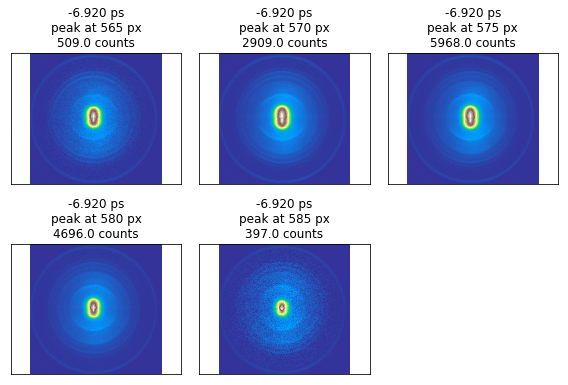

In [6]:
def good_img(img):
    return not np.isnan(img).any()


n = summed['count'].loc[False] + summed['count'].loc[True]
avg = summed['sum'] / summed['count']
diff = (avg.loc[False] - avg.loc[True])
where = (50 < n) & (diff.apply(good_img))
df = pd.DataFrame({
    'img': diff[where].apply(partial(np.einsum, 'ij->ji')),
    'n': n[where],
})

plt.figure(figsize=(8, 16))
for i, ((dt, atmax), img, n) in enumerate(df[['img', 'n']].itertuples()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax} px\n{n} counts")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

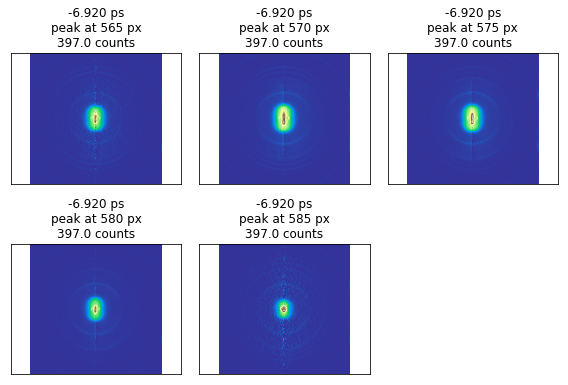

In [7]:
zedges = np.arange(-400, 400 + 1)
redges, thedges = np.linspace(0, 400, 400 + 1), np.linspace(-np.pi, np.pi, 360 + 1)
r = (redges[1:] + redges[:-1]) / 2
th = (thedges[1:] + thedges[:-1]) / 2


def invert_img(d):
    img = d['img']
    img = gaussian_filter(img, 2)
    xn, yn = img.shape
    xedges = np.arange(xn + 1)
    yedges = np.arange(yn + 1)
    f = interp(img, xedges, yedges)
    g = transpose_linearly(f, np.eye(2), x0=np.array([437, 458]))
    transformed = tohist(g, zedges, zedges)

    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    return pd.Series({
        'inverted': inverted,
        'hist_indrdth': hist_indrdth,
        'hist_indrdomega': hist_indrdomega,
    })


df = df.merge(df.apply(invert_img, axis=1), left_index=True, right_index=True)


plt.figure(figsize=(8, 16))
for i, ((dt, atmax), img) in enumerate(df['inverted'].items()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax} px\n{n} counts")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

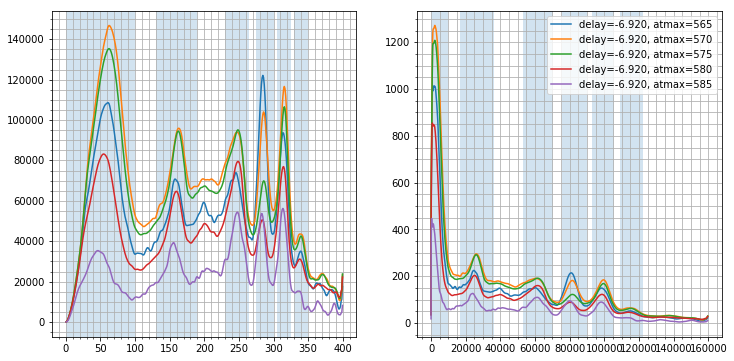

In [8]:
roi = [
    [0, 100],
    [130, 190],
    [230, 265],
    [275, 300],
    [305, 325],
    [330, 350],
]


def f(hist):
    return hist.sum(1)


def intergrateit(hist, fr, to, x=None, **kwargs):
    if x is None:
        x = np.arange(len(hist))
    where = (fr < x) & (x < to)
    return hist[where].sum(**kwargs)


for i, (fr, to) in enumerate(roi):
    df[f'summed{i}_rdist'] = df['hist_indrdth'].apply(intergrateit, fr=fr, to=to, x=r)
    df[f'summed{i}_pad'] = df['hist_indrdomega'].apply(intergrateit, fr=fr, to=to, x=r, axis=0)

plt.figure(figsize=(12, 6))
plt.subplot(121)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r, dist, label=f"delay={dt:.3f},atmax={atmax}")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi:
    plt.axvspan(fr, to, alpha=0.2)

plt.subplot(122)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r**2, dist/2/r, label=f"delay={dt:.3f}, atmax={atmax}")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi:
    plt.axvspan(fr**2, to**2, alpha=0.2)

plt.legend()
plt.show()

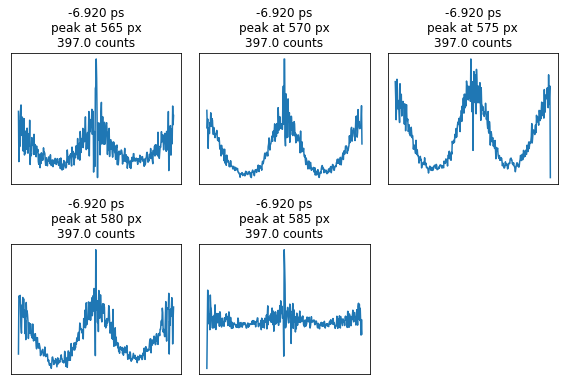

In [9]:
plt.figure(figsize=(8, 16))
for i, ((dt, atmax), pad) in enumerate(df['summed4_pad'].items()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax} px\n{n} counts")
    plt.plot(th, pad)
    plt.xticks([], [])
    plt.yticks([], [])
plt.tight_layout()
plt.show()

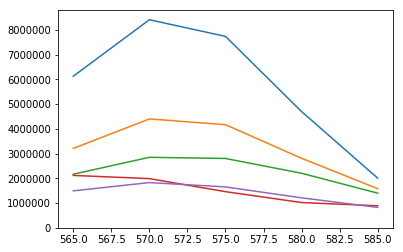

In [11]:
ind = df.index[0][0]

def norm(arr):
    return arr/arr.sum()

plt.plot(df.loc[ind]['summed0_rdist'])
plt.plot(df.loc[ind]['summed1_rdist'])
plt.plot(df.loc[ind]['summed2_rdist'])
plt.plot(df.loc[ind]['summed3_rdist'])
plt.plot(df.loc[ind]['summed4_rdist'])
plt.ylim(0, None)
plt.show()

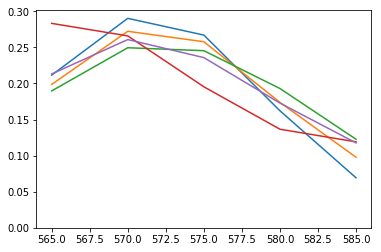

In [12]:
ind = df.index[0][0]

def norm(arr):
    return arr/arr.sum()

plt.plot(norm(df.loc[ind]['summed0_rdist']))
plt.plot(norm(df.loc[ind]['summed1_rdist']))
plt.plot(norm(df.loc[ind]['summed2_rdist']))
plt.plot(norm(df.loc[ind]['summed3_rdist']))
plt.plot(norm(df.loc[ind]['summed4_rdist']))
plt.ylim(0, None)
plt.show()